# Prevendo a nota final dos alunos da Escola Todos Unidos

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor

import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties

from sklearn.model_selection import train_test_split

from graphviz import render

In [2]:
df_notas = pd.read_csv('student-mat.csv')
df_notas.shape

(395, 33)

In [ ]:
df_notas.head(2)

In [ ]:
#Verificação de dados faltantes

In [ ]:
def missing_values_table(df):
        mis_val = df.isnull().sum() # conta a quantidade de missing
        mis_val_percent = 100 * df.isnull().sum() / len(df) # calcula a porcentagem
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1) # cria uma tabela
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Valores faltantes', 1 : '% do total'}) # renomeia as colunas
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% do total', ascending=False).round(1) # ordena os valores
        print ("Você selecionou um dataframe que tem " + str(df.shape[1]) + " colunas.\n"      
            "E há " + str(mis_val_table_ren_columns.shape[0]) +
              " colunas com valores faltantes")
        return mis_val_table_ren_columns

In [ ]:
missing_df = missing_values_table(df_notas)
missing_df.tail()

## Preparação da planilha

### TRATANDO DADOS CATEGÓRICOS: Transformar variáveis categóricas em numéricas

In [3]:
categoricas = ['school',\
               'sex',\
              'address',\
              'famsize',\
               'Pstatus',\
               'Mjob',\
               'Fjob',\
               'reason',\
               'guardian',\
               'schoolsup',\
               'famsup',\
               'paid',\
               'activities',\
               'nursery',\
               'higher',\
               'internet',\
               'romantic',
                ]

In [4]:
from sklearn.preprocessing import LabelEncoder

In [ ]:
from sklearn.preprocessing import OrdinalEncoder

In [ ]:
categoricas[2]

In [5]:
le = LabelEncoder()
# apply le on categorical feature columns
df_notas[categoricas] = df_notas[categoricas].apply(lambda col: le.fit_transform(col))
df_notas[categoricas].head( )

,school,sex,address,famsize,Pstatus,Mjob,Fjob,reason,guardian,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic
0,0,0,1,0,0,0,4,0,1,1,0,0,0,1,1,0,0
1,0,0,1,0,1,0,2,0,0,0,1,0,0,0,1,1,0
2,0,0,1,1,1,0,2,2,1,1,0,1,0,1,1,1,0
3,0,0,1,0,1,1,3,1,1,0,1,1,1,1,1,1,1
4,0,0,1,0,1,2,2,1,0,0,1,1,0,1,1,0,0


In [ ]:
oe = OrdinalEncoder()
categorical = df_notas[categoricas]
oe.fit(categorical)
numerical = oe.transform(categorical)

for n, feat in enumerate(categoricas):
    df_notas[feat] = numerical[:, n]

In [ ]:
df_notas.head()

### Normalização dos dados

In [6]:
from sklearn.preprocessing import StandardScaler

In [7]:
escala = StandardScaler().fit(df_notas)
df_notasN = escala.transform(df_notas)
df_notas = pd.DataFrame(StandardScaler().fit_transform(df_notasN), columns=df_notas.columns, index=df_notas.index)

In [8]:
df_notas.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,-0.36305,-0.948176,1.023046,0.535392,-0.636941,-2.938392,1.143856,1.360371,-1.769793,1.993149,...,0.062194,-0.236010,0.801479,-0.540699,-1.003789,-0.399289,0.036424,-1.782467,-1.254791,-0.964934
1,-0.36305,-0.948176,0.238380,0.535392,-0.636941,0.340322,-1.600009,-1.399970,-1.769793,-0.325831,...,1.178860,-0.236010,-0.097908,-0.540699,-1.003789,-0.399289,-0.213796,-1.782467,-1.520979,-0.964934
2,-0.36305,-0.948176,-1.330954,0.535392,1.570004,0.340322,-1.600009,-1.399970,-1.769793,-0.325831,...,0.062194,-0.236010,-0.997295,0.583385,0.551100,-0.399289,0.536865,-1.179147,-0.722415,-0.090739
3,-0.36305,-0.948176,-1.330954,0.535392,-0.636941,0.340322,1.143856,-0.479857,-0.954077,0.833659,...,-1.054472,-1.238419,-0.997295,-0.540699,-1.003789,1.041070,-0.464016,1.234133,0.874715,1.002004
4,-0.36305,-0.948176,-0.546287,0.535392,-0.636941,0.340322,0.229234,0.440257,-0.138362,-0.325831,...,0.062194,-0.236010,-0.997295,-0.540699,-0.226345,1.041070,-0.213796,-1.480807,-0.190038,-0.090739


In [ ]:
from sklearn.preprocessing import Normalizer

In [ ]:
escala = Normalizer().fit(df_notas)
df_notasN = escala.transform(df_notas)
df_notas = pd.DataFrame(Normalizer().fit_transform(df_notasN), columns=df_notas.columns, index=df_notas.index)

In [ ]:
df_notas.head()

### Construindo gráficos de demonstração de importância das variáveis

In [9]:
X = df_notas.drop('G3', axis=1)
y = df_notas['G3']

In [ ]:
print(X.shape)
print(y.shape)

In [21]:
X

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2
0,-0.363050,-0.948176,1.023046,0.535392,-0.636941,-2.938392,1.143856,1.360371,-1.769793,1.993149,...,-0.708450,0.062194,-0.236010,0.801479,-0.540699,-1.003789,-0.399289,0.036424,-1.782467,-1.254791
1,-0.363050,-0.948176,0.238380,0.535392,-0.636941,0.340322,-1.600009,-1.399970,-1.769793,-0.325831,...,-0.708450,1.178860,-0.236010,-0.097908,-0.540699,-1.003789,-0.399289,-0.213796,-1.782467,-1.520979
2,-0.363050,-0.948176,-1.330954,0.535392,1.570004,0.340322,-1.600009,-1.399970,-1.769793,-0.325831,...,-0.708450,0.062194,-0.236010,-0.997295,0.583385,0.551100,-0.399289,0.536865,-1.179147,-0.722415
3,-0.363050,-0.948176,-1.330954,0.535392,-0.636941,0.340322,1.143856,-0.479857,-0.954077,0.833659,...,1.411533,-1.054472,-1.238419,-0.997295,-0.540699,-1.003789,1.041070,-0.464016,1.234133,0.874715
4,-0.363050,-0.948176,-0.546287,0.535392,-0.636941,0.340322,0.229234,0.440257,-0.138362,-0.325831,...,-0.708450,0.062194,-0.236010,-0.997295,-0.540699,-0.226345,1.041070,-0.213796,-1.480807,-0.190038
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
390,2.754443,1.054656,2.592380,0.535392,1.570004,-2.938392,-0.685387,-0.479857,0.677354,0.833659,...,-0.708450,1.178860,1.768808,0.801479,2.831553,2.105989,0.320890,0.661975,-0.575827,-0.456226
391,2.754443,1.054656,0.238380,0.535392,1.570004,0.340322,0.229234,-1.399970,0.677354,0.833659,...,-0.708450,-2.171138,0.766399,1.700867,1.707469,1.328545,-1.119469,-0.338906,0.932473,1.407091
392,2.754443,1.054656,3.377047,-1.867789,-0.636941,0.340322,-1.600009,-1.399970,-0.138362,-0.325831,...,-0.708450,1.178860,1.768808,-0.097908,1.707469,0.551100,-0.399289,-0.338906,-0.274167,-0.722415
393,2.754443,1.054656,1.023046,-1.867789,1.570004,0.340322,0.229234,-0.479857,0.677354,-0.325831,...,-0.708450,0.062194,0.766399,-1.896683,1.707469,1.328545,1.041070,-0.714236,0.027493,0.342338


In [ ]:
y

In [ ]:
X.columns

## Dados preparados para escolha do tipo de algoritmo

### Teste com RandomForestClassifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
var_imp_RFC = RandomForestClassifier(n_estimators=5)
var_imp_RFC.fit(X, y)

In [ ]:
print(var_imp_RFC.feature_importances_)

In [ ]:
RFC_teste = var_imp_RFC.feature_importances_

# enumerar a ordem de importância da variável neste teste
for i,v in enumerate(RFC_teste):
    print('Feature: %0d, Score: %.5f' % (i,v))

In [ ]:
features_n = X.columns

In [ ]:
# plot feature importance
plt.bar([x for x in range(len(RFC_teste))], RFC_teste)
plt.xticks([x for x in range(len(RFC_teste))], features_n, rotation='vertical')
plt.show()

In [ ]:
#Conclusões até o momento: as variáveis mais significativas são G2 e G1 (obviamente), absences, Walc,
# Mjob, health, goout, Fedu, age

### Teste com DecisionRegressionTree

In [ ]:
# Fit regression model
regr_1 = DecisionTreeRegressor()
regr_1.fit(X, y)
# Predict
y_pred = regr_1.predict(X)

In [ ]:
from sklearn.metrics import r2_score # quanto mais proximo de 1 melhor o modelo
print(r2_score(y, regr_1.predict(X)))

In [ ]:
from sklearn.metrics import mean_absolute_error  # desvio médio entre observado e predito.
mean_absolute_error(y, y_pred)

In [ ]:
# Fit regression model
regr_1 = DecisionTreeRegressor()
regr_1.fit(X, y)
# Predict
y_pred = regr_1.predict(X)

In [ ]:
mean_absolute_error(y, y_pred)

In [ ]:
DTR_teste = regr_1.feature_importances_

# summarize feature importance
for i,v in enumerate(DTR_teste):
    print('Feature: %0d, Score: %.5f' % (i,v))

In [ ]:
features_n = X.columns

In [ ]:
# plot feature importance
plt.bar([x for x in range(len(DTR_teste))], DTR_teste)
plt.xticks([x for x in range(len(DTR_teste))], features_n, rotation='vertical')
plt.show()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42)

In [ ]:
X_test.shape

In [ ]:
X_train.shape

In [ ]:
# Fit regression model
regr_1 = DecisionTreeRegressor(max_depth=4)
regr_1.fit(X_train, y_train)

# Predict
y_pred = regr_1.predict(X_test)

In [ ]:
mean_absolute_error(y_test, y_pred)

In [ ]:
from sklearn.tree import export_graphviz  
  
# export the decision tree to a tree.dot file 
# for visualizing the plot easily anywhere 
export_graphviz(regr_1, out_file ='tree.dot')  

render('dot', 'png', 'tree.dot')  

In [ ]:
from sklearn import tree

# plot tree
plt.figure(figsize=(12,12))  # set plot size (denoted in inches)
tree.plot_tree(regr_1, fontsize=8)
plt.show()


In [ ]:
X

In [ ]:
#Conclusões até agora: aparentemente o DecisionTreeRegression não foi o melhor método

In [ ]:
# Fit regression model
regr_1 = DecisionTreeRegressor(max_depth=4)
regr_1.fit(X, y)



In [ ]:
DTR_teste = regr_1.feature_importances_

# summarize feature importance
for i,v in enumerate(DTR_teste):
    print('Feature: %0d, Score: %.5f' % (i,v))

In [ ]:
features_n = X.columns

In [ ]:
# plot feature importance
plt.bar([x for x in range(len(DTR_teste))], DTR_teste)
plt.xticks([x for x in range(len(DTR_teste))], features_n, rotation='vertical')
plt.show()

In [ ]:
df_notas.iloc[:,31].value_counts()

In [ ]:
df_notas2 = df_notas[(df_notas.iloc[:,31] == 10) & (df_notas.iloc[:,29] == 0) ]

In [ ]:
df_notas2 = df_notas2.drop(['G2', 'absences'], axis=1)

In [ ]:
X = df_notas2.drop('G3', axis=1)
y = df_notas2['G3']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42)

In [ ]:
# Fit regression model
regr_1 = DecisionTreeRegressor(max_depth=4)
regr_1.fit(X_train, y_train)

# Predict
y_pred = regr_1.predict(X_test)

In [ ]:
mean_absolute_error(y_test, y_pred)

In [ ]:
features_n = X.columns

In [ ]:
DTR_teste = regr_1.feature_importances_

# summarize feature importance
for i,v in enumerate(DTR_teste):
    print('Feature: %0d, Score: %.5f' % (i,v))

In [ ]:
# plot feature importance
plt.bar([x for x in range(len(DTR_teste))], DTR_teste)
plt.xticks([x for x in range(len(DTR_teste))], features_n, rotation='vertical')
plt.show()

In [ ]:
#Conclusões até aqui: não funcionou bem esse método ou estou fazendo algo muito errado

### Teste com Recursive Feature Elimination RFE

In [ ]:
#Uso do RandomForestRegressor

In [11]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor
from operator import itemgetter

In [ ]:
#X = df_notas.drop('G3', axis=1)
#y = df_notas['G3']
features = X.columns
X_train       = df_notas[features]
y_train       = y
final_X_test  = df_notas[features]

In [ ]:
regressor = RandomForestRegressor(n_estimators=100, max_depth=10)

In [ ]:
#rfe_notas = RFE(RFE_teste)
# here we want only one final feature, we do this to produce a ranking
n_features_to_select = 1
rfe = RFE(regressor, n_features_to_select)
rfe.fit(X_train, y_train)

In [ ]:
for x, y in (sorted(zip(rfe.ranking_ , features), key=itemgetter(0))):
    print(x, y)

In [ ]:
n_features_to_select = 10
rfe = RFE(regressor, n_features_to_select)
rfe.fit(X_train, y_train)

In [ ]:
predictions = rfe.predict(final_X_test)

In [ ]:
predictions

In [ ]:
#RFE_fit = rfe_notas.fit(X, y)

In [ ]:
#Conclusões até agora: esse tipo não funciona direito ou eu não estou sabendo usar =/

### Regressão Linear

In [ ]:
from sklearn.svm import LinearSVC
from sklearn.feature_selection import RFE

In [ ]:
data = df_notas
X = data.data
y = data.target

In [ ]:
model = LinearSVC()
rfe = RFE(model, step=1).fit(X, y)

### Decision Tree Regressor

In [12]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split

regressor2= DecisionTreeRegressor(random_state = 0)

#Variável teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

#fit tregressor with X and y data
regressor2.fit(X_train, y_train)

DecisionTreeRegressor(random_state=0)

In [13]:
y_pred = regressor2.predict(X_test)

In [14]:
#qualidade do modelo
from sklearn.model_selection import cross_val_score

score = regressor2.score(X_test, y_test)

In [15]:
score

0.8012130245945877

In [16]:
from sklearn import metrics
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred)) #próx de 0, melhor
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred))) #medida de dispersão

Mean Absolute Error: 0.2534430060965329
Mean Squared Error: 0.2087145637551259
Root Mean Squared Error: 0.45685289071551893


### Depois de aplicar o Yellowbrick

In [32]:
df_notas3 = df_notas.drop(['school', 'sex', 'address', 'famsize', 'Pstatus', 'guardian', 'schoolsup', 'famsup', 'paid', 
                           'nursery', 'higher', 'internet', 'romantic', 'Dalc', 'G3'], axis=1)

In [34]:
df_notas3.head()

,age,Medu,Fedu,Mjob,Fjob,reason,traveltime,studytime,failures,activities,famrel,freetime,goout,Walc,health,absences,G1,G2
0,1.023046,1.143856,1.360371,-1.769793,1.993149,-1.040599,0.792251,-0.042286,-0.449944,-1.017881,0.062194,-0.236010,0.801479,-1.003789,-0.399289,0.036424,-1.782467,-1.254791
1,0.238380,-1.600009,-1.399970,-1.769793,-0.325831,-1.040599,-0.643249,-0.042286,-0.449944,-1.017881,1.178860,-0.236010,-0.097908,-1.003789,-0.399289,-0.213796,-1.782467,-1.520979
2,-1.330954,-1.600009,-1.399970,-1.769793,-0.325831,0.616806,-0.643249,-0.042286,3.589323,-1.017881,0.062194,-0.236010,-0.997295,0.551100,-0.399289,0.536865,-1.179147,-0.722415
3,-1.330954,1.143856,-0.479857,-0.954077,0.833659,-0.211896,-0.643249,1.150779,-0.449944,0.982433,-1.054472,-1.238419,-0.997295,-1.003789,1.041070,-0.464016,1.234133,0.874715
4,-0.546287,0.229234,0.440257,-0.138362,-0.325831,-0.211896,-0.643249,-0.042286,-0.449944,-1.017881,0.062194,-0.236010,-0.997295,-0.226345,1.041070,-0.213796,-1.480807,-0.190038


In [35]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
X = df_notas3
y = df_notas['G3']
regressor2= DecisionTreeRegressor(random_state = 0)

#Variável teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

#fit tregressor with X and y data
regressor2.fit(X_train, y_train)

DecisionTreeRegressor(random_state=0)

In [36]:
y_pred = regressor2.predict(X_test)

In [37]:
#qualidade do modelo
from sklearn.model_selection import cross_val_score

score = regressor2.score(X_test, y_test)

In [38]:
score

0.8077118295597645

In [39]:
from sklearn import metrics
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred)) #próx de 0, melhor
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred))) #medida de dispersão

Mean Absolute Error: 0.22956794030483046
Mean Squared Error: 0.20189120301697755
Root Mean Squared Error: 0.4493230497281188


In [43]:
print(X.shape)
print(y.shape)

(395, 18)
(395,)


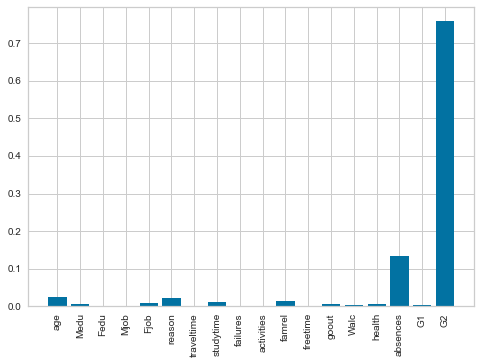

In [45]:
features_n = X.columns
regr_2 = DecisionTreeRegressor()
regr_2.fit(X, y)
DTR_teste = regr_2.feature_importances_
# plot feature importance
plt.bar([x for x in range(len(DTR_teste))], DTR_teste)
plt.xticks([x for x in range(len(DTR_teste))], features_n, rotation='vertical')
plt.show()

## Gráficos Yellowbrick

In [ ]:
!pip install yellowbrick

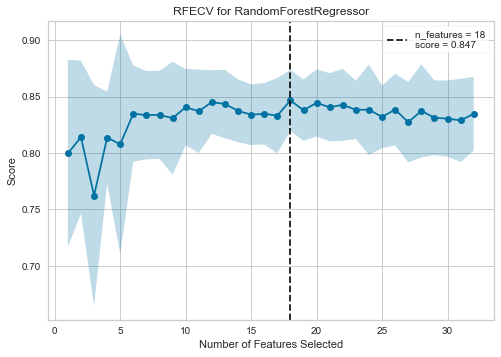

<AxesSubplot:title={'center':'RFECV for RandomForestRegressor'}, xlabel='Number of Features Selected', ylabel='Score'>

In [22]:
from yellowbrick.model_selection import RFECV
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
cv = StratifiedKFold(5)
visualizer = RFECV(RandomForestRegressor(), cv=5, scoring='r2')
visualizer.fit(X, y)
visualizer.show()

In [23]:
X.loc[:, X.columns != 'IN_TREINEIRO'].columns[visualizer.support_] #pegar as colunas que ele retornou como importante

Index(['age', 'Medu', 'Fedu', 'Mjob', 'Fjob', 'reason', 'traveltime',
       'studytime', 'failures', 'activities', 'famrel', 'freetime', 'goout',
       'Walc', 'health', 'absences', 'G1', 'G2'],
      dtype='object')

In [29]:
X.loc[:, X.columns == 'IN_TREINEIRO'].columns[visualizer.support_]

IndexError: boolean index did not match indexed array along dimension 0; dimension is 0 but corresponding boolean dimension is 32

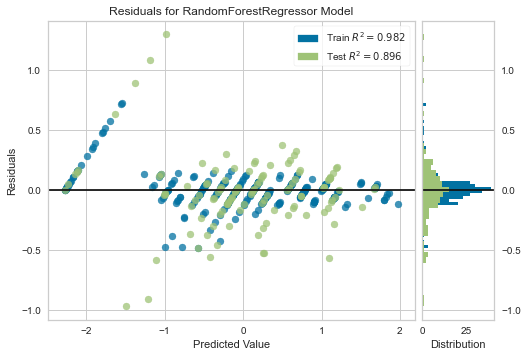

<AxesSubplot:title={'center':'Residuals for RandomForestRegressor Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [47]:
# Teste com outras configurações
from yellowbrick.regressor import ResidualsPlot
#from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

# Create training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3
)

visualizer = ResidualsPlot(RandomForestRegressor())
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.show()

## Recursive feature elimination with cross-validation

In [46]:
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV

X = df_notas3
y = df_notas['G3']
# Create the RFE object and compute a cross-validated score.
svc = SVC(kernel="linear")
# The "accuracy" scoring is proportional to the number of correct
# classifications

min_features_to_select = 1  # Minimum number of features to consider
rfecv = RFECV(estimator=svc, step=1, cv=5,
              scoring='accuracy',
              min_features_to_select=min_features_to_select)
rfecv.fit(X, y)

print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(min_features_to_select,
               len(rfecv.grid_scores_) + min_features_to_select),
         rfecv.grid_scores_)
plt.show()

ValueError: Unknown label type: 'continuous'

### Recursive Feature Elimination

In [ ]:
from sklearn.svm import SVC
from sklearn.feature_selection import RFE

# Create the RFE object and rank
svc = SVC(kernel="linear", C=1)
rfe = RFE(estimator=svc, n_features_to_select=1, step=1)
rfe.fit(X, y)
ranking = rfe.ranking_.reshape()

# Plot pixel ranking
plt.matshow(ranking, cmap=plt.cm.Blues)
plt.colorbar()
plt.title("Ranking of Features with RFE")
plt.show()